In [1]:
from ssri_interactions.interactions.preprocessors import InteractionsPreprocessor
from ssri_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from ssri_interactions.interactions.pairwise import PairwiseCorr
from ssri_interactions.io import load_neurons, load_derived_generic
import seaborn as sns
import pandas as pd
import numpy as np
from ssri_interactions.interactions.graph_clustering import SpectralCluster, ClusterRunner, ClusterEvaluation, ClusterResults
import warnings
from ssri_interactions.config import Config, ExperimentInfo
from tqdm import tqdm

dd = Config.derived_data_dir / "ensembles"
dd.mkdir(exist_ok=True)
sns.set_theme(style="ticks", context="paper")

c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def load_responders():
    slow_responders_shock = (
        load_derived_generic("slow_ts_foot_shock_unit_responders_pre_to_shock.csv")
        [["neuron_id", "response"]]
        .rename(columns={"response": "response_fs_slow"})
    )
    fast_responders_first_window = (
        load_derived_generic("fast_fs_foot_shock_unit_responders.csv")
        [["neuron_id", "fs_fast_response"]]
    )
    fast_responders_second_window = (
        load_derived_generic("fast_fs_foot_shock_unit_responders_second_window.csv")
        [["neuron_id", "response_second_window"]]
    )
    neuron_types = load_derived_generic("neuron_types.csv")[["neuron_id", "neuron_type", "session_name", "group"]]
    df_responders = (
        slow_responders_shock
        .merge(fast_responders_first_window, how="outer")
        .merge(fast_responders_second_window, how="outer")
        .merge(neuron_types, how="left")
    )
    return df_responders

    

In [3]:
neuron_types = load_derived_generic("neuron_types.csv").query("group in ('CIT', 'SAL')")
sessions = neuron_types.query("experiment_name == 'HAMILTON'").session_name.unique().tolist()

preprocessor = InteractionsPreprocessor(z=True, minmax=False)
evaluator = ClusterEvaluation()

loader_fac = lambda session, block, bin_width: BaseShockSlowInteractionsLoader(
    session_name=session, block=block, bin_width=bin_width,
)
corr_fac = lambda: PairwiseCorr(
    remove_self_interactions=True,
    rectify=True,
    shuffle=False,
    remove_duplicate_combs=True,
)
cluster_fac = lambda: SpectralCluster(
    n_clusters=np.arange(2, 8), spectral_kws={"affinity": "precomputed"}, n_init=3
)

runner_fac = lambda session, block, bin_width: ClusterRunner(
    loader=loader_fac(session=session, block=block, bin_width=bin_width),
    preprocessor=preprocessor,
    affinity_calculator=corr_fac(),
    clusterer=cluster_fac(),
    evalulator=evaluator,
)

In [5]:
ensemble_frames = []
ensemble_stats_frames = []

for bin_width in (0.05, 0.1, 0.5, 1):
    for block in ("pre", "base_shock"):
        for session in tqdm(sessions):
            # calculate ensembles
            runner = runner_fac(session=session, block=block, bin_width=bin_width)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, ensembles, _, ensemble_stats = runner.run(20)
                except ValueError as e:
                    print(e)
                    print(session)
                    continue

            # add metadata and append to list of results
            ensembles = ensembles.assign(session_name=session, block=block, bin_width=bin_width)
            ensemble_stats = ensemble_stats.assign(session_name=session, block=block, bin_width=bin_width)
            ensemble_stats_frames.append(ensemble_stats)
            ensemble_frames.append(ensembles)


df_ensembles = pd.concat(ensemble_frames).reset_index(drop=True)
df_ensembles_stats = pd.concat(ensemble_stats_frames).reset_index(drop=True)

df_ensembles_stats["ensemble_id"] = pd.factorize(
    df_ensembles_stats["ensemble"].astype(str)
    + df_ensembles_stats["session_name"]
    + df_ensembles_stats["block"]
    + df_ensembles_stats["bin_width"].astype(str)
)[0]
df_ensembles_stats["ensemble_id"] = np.where(
    df_ensembles_stats["ensemble"] == -1,
    -1,
    df_ensembles_stats["ensemble_id"],
)
df_ensembles = (
    df_ensembles.merge(
    df_ensembles_stats[["session_name", "ensemble", "ensemble_id", "block", "bin_width"]],
    on=["session_name", "ensemble", "block", "bin_width"]
    )
)

df_ensembles.to_csv(dd / "fs - ensembles.csv", index=False)
df_ensembles_stats.to_csv(dd / "fs - stats.csv", index=False)


100%|██████████| 9/9 [06:53<00:00, 45.99s/it]


### Descrip 1s Ensembles

In [43]:
# make true df_ensemble and df_ensembles_stats and global ensemble ID

df_ensembles = pd.read_csv(dd / "fs - ensembles.csv", ).drop_duplicates().loc[lambda x: x.bin_width == 1]
df_ensembles_stats= pd.read_csv(dd / "fs - stats.csv").drop_duplicates().loc[lambda x: x.bin_width == 1]
neuron_types = (
    load_derived_generic("neuron_types.csv")
    .loc[lambda x: ~x.neuron_type.isna()]
)
df_responders = load_responders()

descriptor = ClusterResults(neuron_types=neuron_types)
stats2 = descriptor.ensemble_results(df_ensembles, df_ensembles_stats)
response_entropy = descriptor.ensemble_response_entropy(
    df_ensembles, 
    df_response=df_responders,
    df_response_response_col="response_fs_slow",
    created_col = "response_fs_entropy"
)
stats2 = stats2.merge(response_entropy)


df_ensembles.to_csv(dd / "fs - ensembles - true.csv", index=False)
stats2.to_csv(dd / "fs - stats - true.csv", index=False)

In [44]:
stats2 = stats2.merge(
    neuron_types[["session_name", "group"]].drop_duplicates(),
)

<AxesSubplot:ylabel='ensemble_id'>

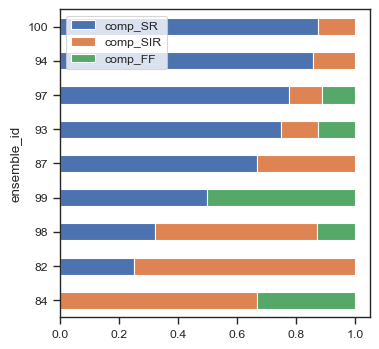

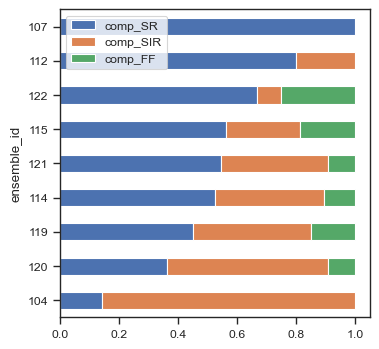

In [45]:
pre = (
    stats2
    .query("block == 'pre' and group == 'SAL'")
    .query("ensemble_id != -1")
    .set_index("ensemble_id")
    [["comp_SR", "comp_SIR", "comp_FF",]]
    .fillna(0)
    .sort_values("comp_SR")
)
pre.plot(kind="barh", stacked=True, figsize=(4, 4))

shock = (
    stats2
    .query("block == 'base_shock' and group == 'SAL'")
    .query("ensemble_id != -1")
    .set_index("ensemble_id")
    [["comp_SR", "comp_SIR", "comp_FF",]]
    .fillna(0)
    .sort_values("comp_SR")
)
shock.plot(kind="barh", stacked=True, figsize=(4, 4))


<AxesSubplot:ylabel='ensemble_id'>

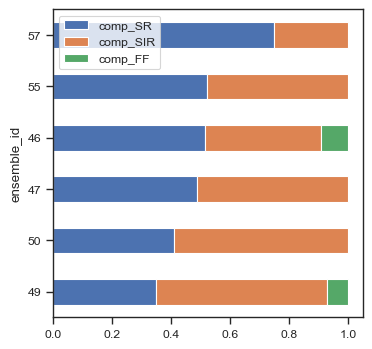

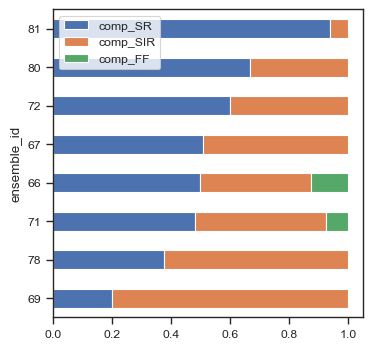

In [42]:
pre = (
    stats2
    .query("block == 'pre' and group == 'CIT'")
    .query("ensemble_id != -1")
    .set_index("ensemble_id")
    [["comp_SR", "comp_SIR", "comp_FF",]]
    .fillna(0)
    .sort_values("comp_SR")
)
pre.plot(kind="barh", stacked=True, figsize=(4, 4))

shock = (
    stats2
    .query("block == 'base_shock' and group == 'CIT'")
    .query("ensemble_id != -1")
    .set_index("ensemble_id")
    [["comp_SR", "comp_SIR", "comp_FF",]]
    .fillna(0)
    .sort_values("comp_SR")
)
shock.plot(kind="barh", stacked=True, figsize=(4, 4))


# sns.barplot(data=pre, hue="variable", y="value", x="ensemble_id", )